# Visual Inspection of Motorcycle Connecting Rods
Author: Matteo Periani<br>
student-id: 0001039848<br>
date: 11/2022


In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist

## Import image
Import first image

In [43]:
img_path = "./images/task2/task21/TESI44.BMP"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

Apply median blur filter severl times to remove disturbing dust and refine edges

In [11]:
# APPLICATIONS = 4
# KERNEL_SIZE = 3

# for i in range(APPLICATIONS):
#     img = cv2.medianBlur(img, KERNEL_SIZE)

Binirize image with Otsu' method

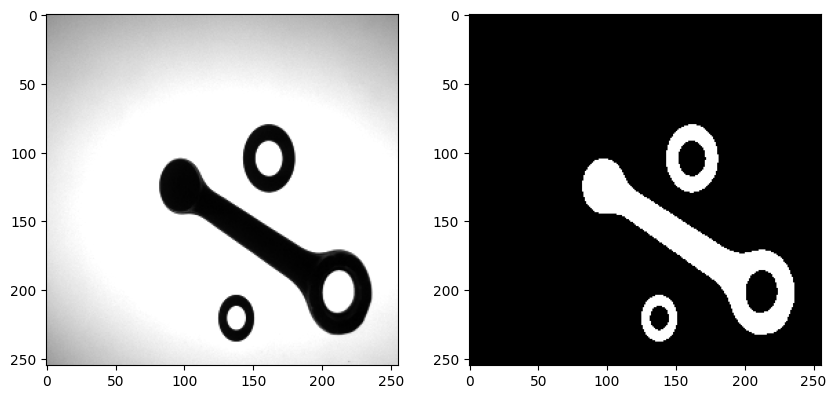

In [50]:
tresh, binarized_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

f, plts = plt.subplots(1, 2, figsize=(10,10)) 
plts[0].imshow(img, cmap="gray")
plts[1].imshow(binarized_img, cmap="gray")
plt.show()

Compute connected components

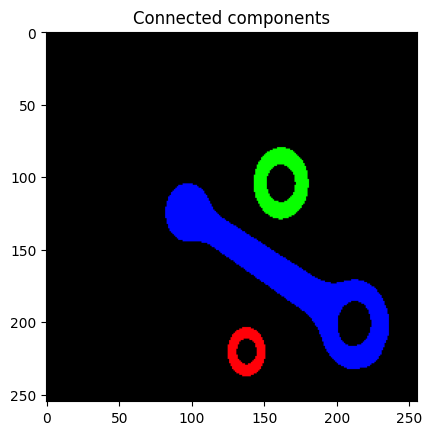

In [51]:
CONNECTIVITY = 8

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binarized_img, connectivity=CONNECTIVITY)

label_hue = np.uint8(179 * labels / np.max(labels))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2RGB)
labeled_img[label_hue == 0] = 0

plt.imshow(labeled_img)
plt.title("Connected components")
plt.show()

## Detect holes & remove not rod components

In [45]:
def get_component(labels, label):
    component = np.zeros_like(labels, dtype=np.uint8)
    component[labels == label] = 255

    return component

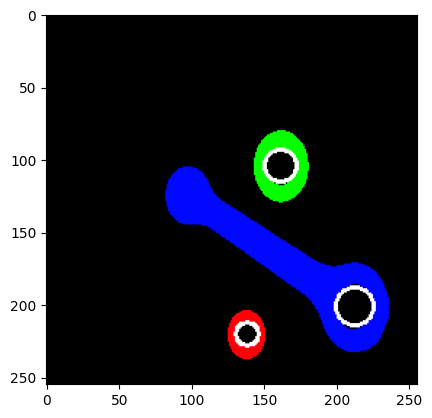

In [52]:
holes = []

for i in range(1, num_labels):
    component = get_component(labels, i)

    num_labels_c, labels_c, stats_c, centroids_c = cv2.connectedComponentsWithStats(255 - component, connectivity=CONNECTIVITY)

    c_holes = []
    for j in range(2, num_labels_c):
        diameter = math.sqrt(stats_c[j][4] / math.pi)

        hole = (centroids_c[j], diameter)
        c_holes.append(hole)

    holes.append(c_holes)

    # if the object not contains holes, it is removed from the image
    if len(c_holes) == 0:
        labels[component == 255] = 0
        labeled_img[component == 255] = 0 # just for visualization purpose
    


draw_hole_img = labeled_img.copy()
for c_hole in holes:
    for hole in c_hole:
        draw_hole_img = cv2.circle(draw_hole_img, np.rint(hole[0]).astype(int),  round(hole[1]), (255,255,255), 2)

plt.imshow(draw_hole_img)
plt.show()

## Compute moments

In [53]:
def compute_theta(moments):
    if (moments['mu20'] - moments['mu02']) == 0:
        return None
    
    theta = -0.5 * math.atan(2 * moments['mu11'] / (moments['mu20'] - moments['mu02']))

    d2theta = 2 * (moments['mu20'] - moments['mu02']) * math.cos(2 * theta) - 4 * moments['mu11'] * math.sin(2 * theta)

    if d2theta > 0:
        return theta
    else:
        return theta + math.pi / 2

def find_mer(component, angle, centroid):
    alpha = -math.sin(angle)
    beta = math.cos(angle)

    major = (alpha, -beta, beta * centroid[1] - alpha * centroid[0])
    minor = (beta, alpha, -beta * centroid[0] - alpha * centroid[1])

    c1 = c2 = c3 = c4 = (0, 0)

    max_c1_maj = max_c3_min = float("-inf")
    min_c2_maj = min_c4_min = float("inf")

    contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for p in contours[0]:
        x = p[0][0]
        y = p[0][1]

        dist_maj = (major[0] * x + major[1] * y + major[2]) / math.sqrt(major[0] ** 2 + major[1] ** 2)
        dist_min = (minor[0] * x + minor[1] * y + minor[2]) / math.sqrt(minor[0] ** 2 + minor[1] ** 2)

        # If distance from the major axis is greater than the maximum ever encountered
        if dist_maj > max_c1_maj:
            c1 = (x, y)
            max_c1_maj = dist_maj

        # If distance from the major axis is less than the minimum ever encountered
        if dist_maj < min_c2_maj:
            c2 = (x, y)
            min_c2_maj = dist_maj

        # If distance from the minor axis is greater than the maximum ever encountered
        if dist_min > max_c3_min:
            c3 = (x, y)
            max_c3_min = dist_min

        # If distance from the minor axis is less than the minimum ever encountered
        if dist_min < min_c4_min:
            c4 = (x, y)
            min_c4_min = dist_min

    # Declare a, b, a', b'
    a = alpha
    b = -beta
    a_p = beta
    b_p = alpha

    # Calculate 'c' coefficients for lines of MER's sides
    cl_1 = -(a * c1[0] + b * c1[1])
    cl_2 = -(a * c2[0] + b * c2[1])
    cw_1 = -(a_p * c3[0] + b_p * c3[1])
    cw_2 = -(a_p * c4[0] + b_p * c4[1])

    # Calculate MER vertices
    v1_x = (b * cw_1 - b_p * cl_1) / (a * b_p - b * a_p)
    v1_y = (a_p * cl_1 - a * cw_1) / (a * b_p - b * a_p)
    v1 = (v1_x, v1_y)

    v2_x = (b * cw_2 - b_p * cl_1) / (a * b_p - b * a_p)
    v2_y = (a_p * cl_1 - a * cw_2) / (a * b_p - b * a_p)
    v2 = (v2_x, v2_y)

    v3_x = (b * cw_1 - b_p * cl_2) / (a * b_p - b * a_p)
    v3_y = (a_p * cl_2 - a * cw_1) / (a * b_p - b * a_p)
    v3 = (v3_x, v3_y)

    v4_x = (b * cw_2 - b_p * cl_2) / (a * b_p - b * a_p)
    v4_y = (a_p * cl_2 - a * cw_2) / (a * b_p - b * a_p)
    v4 = (v4_x, v4_y)

    # Declare MER as the quadruple of vertices
    mer = (v1, v2, v3, v4)

    # Calculate length and width as euclidean distance
    length = dist.euclidean(v1, v2)
    width = dist.euclidean(v1, v3)

    return mer, length, width

def get_barycenter_width(component, angle, centroid):
    # Calculate alpha and beta
    alpha = -math.sin(angle)
    beta = math.cos(angle)

    # Get major and minor axis
    major = (alpha, -beta, beta * centroid[1] - alpha * centroid[0])
    minor = (beta, alpha, -beta * centroid[0] - alpha * centroid[1])

    # Points at barycenter width (to be detected)
    wb_1 = wb_2 = (0, 0)
    min_wb_1 = min_wb_2 = float("inf")

    # Get object contour
    contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Iterate over contour points only (since points at barycenter width belong to them)
    for p in contours[0]:
        x = p[0][0]
        y = p[0][1]

        # Calculate signed distances between major and minor axis
        dist_maj = (major[0] * x + major[1] * y + major[2]) / math.sqrt(major[0] ** 2 + major[1] ** 2)
        dist_min = (minor[0] * x + minor[1] * y + minor[2]) / math.sqrt(minor[0] ** 2 + minor[1] ** 2)

        # If the absolute distance from the minor axis is less than the minimum ever encountered
        # for wb_1 AND the distance from the major axis is positive
        if abs(dist_min) < min_wb_1 and dist_maj > 0:
            wb_1 = (x, y)
            min_wb_1 = abs(dist_min)

        # If the absolute distance from the minor axis is less than the minimum ever encountered
        # for wb_2 AND the distance from the major axis is negative
        if abs(dist_min) < min_wb_2 and dist_maj < 0:
            wb_2 = (x, y)
            min_wb_2 = abs(dist_min)

    # Calculate width as euclidean distance
    width = dist.euclidean(wb_1, wb_2)

    # Declare the double of points at barycenter width
    wb_points = [wb_1, wb_2]

    return wb_points, width

In [9]:
def print_rod_info(centroid, mer, angle, length, width, bar_width, holes, c):
    string = ""
    rod_type = "Not a rod"

    if len(holes[c]) == 1:
        rod_type = "A"
    elif len(holes[c]) == 2:
        rod_type = "B"

    string += "Rod type:\t" + rod_type + "\n"
    string += "Position:\tCentroid = (" + "{:.2f}".format(centroid[0]) + ", " + "{:.2f}".format(
        centroid[1]) + ")\n\t\tMER = ((" + "{:.2f}".format(mer[0][0]) + ", " + "{:.2f}".format(
        mer[0][1]) + "), (" + "{:.2f}".format(mer[1][0]) + ", " + "{:.2f}".format(
        mer[1][1]) + "), (" + "{:.2f}".format(mer[2][0]) + ", " + "{:.2f}".format(mer[2][1]) + "), (" + "{:.2f}".format(
        mer[3][0]) + ", " + "{:.2f}".format(mer[3][1]) + "))\n"
    string += "Orientation:\t" + "{:.2f}".format(angle * 180 / math.pi) + " deg\n"
    string += "Size:\t\tLength = " + "{:.2f}".format(length) + "\n\t\tWidth = " + "{:.2f}".format(
        width) + "\n\t\tBarycenter width: " + "{:.2f}".format(
        bar_width) + "\n"
    string += "Holes:\t\t"

    if len(holes[c]) == 0:
        string += "None"
    else:
        for i, h in enumerate(holes[c]):
            if i > 0:
                string += "\t\t"

            string += "Hole " + str(i + 1) + ":\tCentroid = (" + \
                      "{:.2f}".format(h[0][0]) + ", " + \
                      "{:.2f}".format(h[0][1]) + ")\n\t\t\tDiameter: " + \
                      "{:.2f}".format(h[1]) + "\n"

    print(string)

Rod type:	A
Position:	Centroid = (162.50, 168.53)
		MER = ((249.93, 193.19), (100.40, 90.11), (217.43, 240.33), (67.90, 137.25))
Orientation:	-34.58 deg
Size:		Length = 181.00
		Width = 57.26
		Barycenter width: 21.40
Holes:		Hole 1:	Centroid = (211.64, 201.16)
			Diameter: 13.36



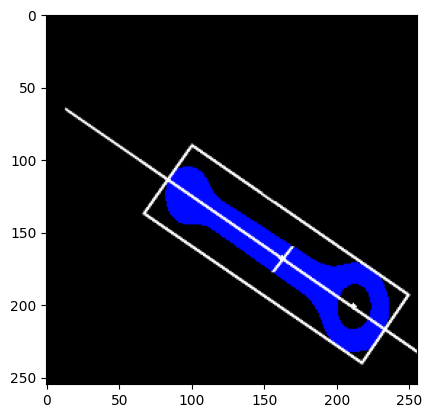

In [59]:
visualization = True

for i in range(1, num_labels):
    component = get_component(labels, i)

    num_labels_c, labels_c, stats_c, centroids_c = cv2.connectedComponentsWithStats(255 - component, connectivity=CONNECTIVITY)

    # get baricenter points and width
    moments = cv2.moments(component, binaryImage = True)
    theta = compute_theta(moments)
    bar_points, bar_width = get_barycenter_width(component, theta, centroids[i])

    # finde MER
    mer, length, width = find_mer(component, theta, centroids[i])

    enlongatedness = length / width

    # if the object ins't a rod, it's ignored and removed from image (just for visualization purpose)
    if len(holes[i-1]) == 0 or enlongatedness < 1.8:
        labeled_img[component == 255] = 0 # just for visualization purpose
        continue
    
    # iteration over holes
    for j in range(2, num_labels_c):
        component_c = get_component(labels_c, j)

        moments_c = cv2.moments(component_c, True)
        theta_c = compute_theta(moments_c)

        # draw centroids
        cv2.circle(labeled_img, (int(centroids_c[j][0]), int(centroids_c[j][1])), 2, (255, 255, 255), -1) 

    
    print_rod_info(centroids[i], mer, theta, length, width, bar_width, holes, i-1)

    # ----- VISUALIZATION -----
    if visualization:
        # draw centroids
        cv2.circle(labeled_img, (int(centroids[j][0]), int(centroids[j][1])), 2, (255, 255, 255), -1)

        # draw mer
        v1, v2, v3, v4 = mer[0], mer[1], mer[2], mer[3]
        cv2.line(labeled_img, (int(v1[0]), int(v1[1])), (int(v3[0]), int(v3[1])), (255, 255, 255), 1, cv2.LINE_AA)
        cv2.line(labeled_img, (int(v2[0]), int(v2[1])), (int(v1[0]), int(v1[1])), (255, 255, 255), 1, cv2.LINE_AA)
        cv2.line(labeled_img, (int(v3[0]), int(v3[1])), (int(v4[0]), int(v4[1])), (255, 255, 255), 1, cv2.LINE_AA)
        cv2.line(labeled_img, (int(v4[0]), int(v4[1])), (int(v2[0]), int(v2[1])), (255, 255, 255), 1, cv2.LINE_AA)

        # draw orentation axis
        # length = int(length * 1.3 / 2)
        length = int(length)
        alpha = -math.sin(theta)
        beta = math.cos(theta)

        p1 = (int(centroids[i][0] + length * beta),
            int(centroids[i][1] + length * alpha))

        p2 = (int(centroids[i][0] - length * beta),
            int(centroids[i][1] - length * alpha))

        cv2.line(labeled_img, (p1[0], p1[1]), (p2[0], p2[1]), (255, 255, 255), 1, cv2.LINE_AA)

        # draw baricentre width
        p1, p2 = bar_points[0], bar_points[1]

        cv2.line(labeled_img, (p1[0], p1[1]), (p2[0], p2[1]), (255, 255, 255), 1, cv2.LINE_AA)

plt.imshow(labeled_img)
plt.show()